We need to access OpenAI API. I use the older version, but there is a new one (1.xx), which is functionally equivalent for these purposes but with a different syntax. Feel free to modify the prompt function if you want to use the latest openai package.

In [ ]:
# installs openai package
!pip install openai==0.28
# installs pymatgen package which is used to compare materials
!pip install pymatgen
# installs matplotlib package which is used for parity plot
!pip install matplotlib

We'll use pandas to have data in a nice data structure, and time to keep track of created files

In [ ]:
#pandas for dataframes
import pandas as pd
#regex
import re
#openai for chatGPT
import openai
from time import strftime
import pymatgen
from pymatgen.core.structure import Composition
# Comma Seperated Values for the data
import csv
import math
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

This is a simple function to help send and receive data from ChatGPT API. It loops up to 5 times in case OpenAI fails (which happens randomly sometimes). Here you'd also adjust the model parameters, according to the OpenAI API reference (start here: https://platform.openai.com/docs/api-reference/chat)

In [ ]:
def prompt(Q):
  tries = 0
  while tries<5:
    try:
      response = openai.ChatCompletion.create(
        model=mmodel,
        messages=Q,
        temperature=0.7,
        #max_tokens=tkn,
        #frequency_penalty=0,
        presence_penalty=1,
        request_timeout=199
      )['choices'][0]['message']['content']
      break
    except Exception as e:
      tries = tries+1
      print(f"An error occurred {tries:d}th time: {e}")
  return (Q,response)

Get time and date for convenient file naming

In [ ]:
dtime = strftime("%Y_%m_%d-%H%M%S")

Here you choose the model to use and provide the API key


In [ ]:
mmodel = "gpt-3.5-turbo-1106"
openai.api_key = ""

Here we have the prompts we will be using, as well as the system prompt which servers as a general global set of instructions or information. The system prompt may be left empty.

I have two prompts, one asks to generate a table, and the second one iteratively asks to continue that table. This is likely not an optimal approach, but it gives some results so a good example.

I also separated the property from the prompt so that I can vary the property and keep the same prompts, and the othery way around. It does not have to be that way if more task specific prompts work better.

In [ ]:
# Load the CSV file from our local google drive folder
file_path = './drive/MyDrive/ML4ER_LLM/ground_truth_ccr_data.csv'
# makes it a pandas dataframe for the ground truth database
gt_df = pd.read_csv(file_path)
# Display the first few rows of the dataframe to understand its structure
# db_df['Material']
# db_df['Value (K/s)']
gt_df.head()

,Material,Value (K/s)
0,Ag10Cu45Zr45,8.100000e-01
1,Al0.07602085Cu49.95655951Gd0.01086012Zr49.9565...,1.000000e+01
2,Al16Ce32Co5Cu10La32Ni5,5.000000e-01
3,B18Fe27.2Nb4Ni40.8Si10,4.930000e+01
4,Ag50Cu50,1.000000e+10


In [ ]:
def remove_non_alphanumeric(s):
    if len(s.split()) > 1:
        return None  # Remove the entire string if it has more than one word
    return re.sub(r'[^a-zA-Z0-9]', '', s)

In [ ]:
# Converts the dataframe of ground truth values into a dictionary
gt_df_copy = gt_df.copy()
gt_df_copy.set_index('Material' , inplace =True)
gt_dict = gt_df_copy['Value (K/s)'].to_dict()
print(gt_dict)

{'Ag10Cu45Zr45': 0.81, 'Al0.07602085Cu49.95655951Gd0.01086012Zr49.95655951': 10.0, 'Al16Ce32Co5Cu10La32Ni5': 0.5, 'B18Fe27.2Nb4Ni40.8Si10': 49.3, 'Ag50Cu50': 10000000000.0, 'Al85Co2Fe2Ni5Y6': 1500.0, 'Al86Co2La1.5Ni6Y4.5': 3010.0, 'Al87Ce4Ni9': 10200.0, 'Ag5.5Au49Cu26.9Pd2.3Si16.3': 500.0, 'Co': 10000000000.0, 'B6C15Co50Cr15Mo14': 1000.0, 'Cu50Zr50': 250.0, 'Ag8Al8Cu36Zr48': 6.4, 'Al10Cu40Zr50': 27.2, 'Al7Cu46Gd1Zr46': 10.0, 'Al8Cu46Zr46': 40.0, 'Al7Cu46Zr47': 370.0, 'Cu46Zr54': 54100.0, 'Cu47Ni8Si1Ti33Zr11': 10.85, 'Cu47Ni8Ti34Zr11': 1.0, 'Al4Cu48Zr48': 40.0, 'Cu50Ti35Zr15': 4820.0, 'Cu50Ti7.5Zr42.5': 213.0, 'Cu50Ti45Zr5': 734000.0, 'Cu54Ni6Ti18Zr22': 27.7, 'Cu56Zr44': 40000.0, 'Cu60Ti10Zr30': 180.0, 'Cu60Ti7.5Zr32.5': 138.0, 'Cu64Zr26': 432.0, 'Cu64Zr36': 9780.0, 'Cu25Hf25Ti25Zr25': 100.0, 'B6Fe40Ni40P14': 1000000.0, 'B6C15Co7Cr15Fe41Mo14Y2': 80.0, 'B8.88C15.94Cr15.98Fe42.87Mo16.33': 549.0, 'B19.2Co28.8Fe43.2Nb4Si4.8': 250.0, 'B4.3C15.5Co7.3Cr14.7Fe43.7Mo12.6Y1.9': 80.0, 'B6C15Cr15Fe

In [ ]:
PROPERTY = 'Critical cooling rate'
same_value = 0
role_msg = 'You are the top expert in the world in finding critical cooling rates of specific metallic glasses. You are highly accurate and strive to provide correct cooling rate values for the chemical composition requested by the user. You always think step by step on how to give the correct critical cooling rate value. You also provide citations to scientific journals, papers, or online websites based on where you derived your critical cooling rate value from. At the end, your response always includes a singular number for what you think the critical cooling rate value is, not a range of numbers. Remember that the value a critical cooling rate can take on can be either a really big number or really small number depending on the material. Try to provide a numerical answer no matter, but do not hallucinate values. Make sure your critical cooling rate value is directly based on the exact material that the user is requesting the value for. The data you give is being used in important scientific studies so ensure that the values you provide are very accurate. Be prepared to give the critical cooling rate for any metallic glass requested by the user, which will be given in the form of a chemical composition.'
msg = [{"role": "system", "content": role_msg}]
gpt_dict = {}
final_dict = {}
gt_vals_csv = []
gpt_vals_csv = []

i = 0
for key in gt_dict:
  val_list = []
  msg.clear()
  og_key = key
  qs = 'Give me the critical cooling rate value for: ' + key
  msg.append({"role": "system", "content": qs})
  msg, ans = prompt(msg)
  #print(ans)
  # A bunch of regex work to extract the exact number from the entire prompt response from chatGPT
  match = re.search(r'\b(\d+(\.\d+)?)(\^(\d+))?\b', ans)
  output_regex = None
  if match:
    whole_number = match.group(0)  # Entire matched number
    left_side = float(match.group(1))  # Digits before the decimal point
    right_side = int(match.group(4)) if match.group(4) else None  # Exponent or None
    if '.' in match.group(0):  # Check if decimal point exists
        #print(float(whole_number))
        output_regex = float(whole_number)

    elif right_side is not None:
        result = math.pow(left_side, right_side)
        output_regex = float(result)
    else:
        output_regex = float(whole_number)
  else:
    print("NOT FOUND")
    continue
  if (gt_dict[key] > output_regex):
    if (output_regex * 2 >= gt_dict[key]):
      diff = gt_dict[key] - output_regex
      percent_diff = (diff / output_regex) * 100
      rounded_pec = round(percent_diff , 2)
      val_list.append(output_regex)
      val_list.append(gt_dict[key])
      val_list.append(rounded_pec)
      final_dict[key] = val_list
      i = i + 1
      print(key)
      print(rounded_pec)
  else:
      if (gt_dict[key] * 2 >= output_regex):
        diff = output_regex - gt_dict[key]
        percent_diff = (diff / output_regex) * 100
        rounded_pec = round(percent_diff , 2)
        val_list.append(output_regex)
        val_list.append(gt_dict[key])
        val_list.append(rounded_pec)
        final_dict[key] = val_list
        i = i + 1
        print(key)
        print(rounded_pec)



print(str(i) + " out of " + str(len(gt_dict)) + " Matches Found, success rate: " + str(round((i / len(gt_dict)) * 100)) + "%")


material_set = set()
moving_dict = {}
bool = True # boolean for if the CSV is empty, value is true if it is empty
final_data_path = '/content/sample_data/matches.csv'
with open(final_data_path , 'r') as file:
  reader = csv.reader(file) # Reads CSV to see if it is empty, if it's not it reads it all back
  try:
    next(reader)
    bool = False
    for row in reader:
      material_set.add(row[0])
  except:
    pass

for key in final_dict:
  initial_length = len(material_set)
  material_set.add(key)
  after_length = len(material_set)
  if (initial_length != after_length):
    moving_dict[key] = final_dict[key]




# Populates the CSV with the initial group of data
if bool:
  bool = False
  with open(final_data_path , 'w') as file: # Writing
    writer = csv.writer(file)
    for key,value in final_dict.items():
      writer.writerow([key,value[0],value[1],value[2]])
else: # Appends the new data to the CSV if the CSV is already populated
    with open(final_data_path , 'a') as file: # Appending
      writer = csv.writer(file)
      for key,value in moving_dict.items():
        writer.writerow([key,value[0],value[1],value[2]])

# Read back the predicted values and observed values and store them in two lists for use in a parity plot

# avg_diff = 0 # average percent difference
# with open(final_data_path , 'r') as file:
#   reader = csv.reader(file)
#   count = 0
#   sum = 0
#   for row in reader:
#     gpt_vals_csv.append(row[1])
#     gt_vals_csv.append(row[2])
#     sum = sum + float(row[3])
#     count += 1
#   avg_diff = sum / count






#print(gpt_dict)
#qs = ["Provide me with a list of "+PROPERTY+" values for different metallic glasses. Your response should be a table consisting of 2 columns: material, value. Make sure that the data is in these two columns no matter what. The materials have to be typed as unique chemical compositions consisting of chemical element abbreviations and numbers only (e.g. GaAs, but not Gallium Arsenide). Make sure the materials listed actually exist and are not made up. The values have to be single numbers, not ranges and need to be in K/s units. Search through all of the internet and try get data from credible academic journals and papers relating to metallic glasses to generate accurate data. Type out as many different values as you can. You are not allowed to type anything else than this table.",
 #     "Continue to expand the table  with new values of "+PROPERTY+" for more metallic glasses while making sure you do not have duplicate entries for the same metallic glass. Type out as many different values as you can. Search through all of the internet and try get data from credible academic journals and papers relating to metallic glasses to generate accurate data. You are not allowed to type anything else than this table."]
#qs = ["Conduct a comprehensive search across academic and scientific online resources to compile a list of "+PROPERTY+" values for various metallic glasses. Present the data in a table with two columns: 'Material' and 'Value'. For the 'Material' column, use standard chemical notation for unique chemical compositions (e.g., 'GaAs' instead of 'Gallium Arsenide'). Ensure the listed materials are real and not hypothetical. For the 'Value' column, provide exact numbers in K/s units, avoiding ranges. Prioritize data from credible and authoritative academic journals and scientific papers on metallic glasses. Type out as many different values as you can while ensuring accuracy and relevance. You are not allowed to type anything else than this table." , "Continue expanding the current table with new " +PROPERTY+ " values for additional metallic glasses. Ensure that each entry is unique and does not duplicate previously listed metallic glasses. Aim to include as many distinct values as possible, adhering to these guidelines: 1. Focus exclusively on different metallic glasses not covered in the previous response. 2. Prioritize data sourced from credible, peer-reviewed academic journals and scientific papers. 3. Continue to clearly represent the material using standard chemical notation. 4. Provide values as single numbers in K/s units, without ranges. 6. Limit the search to additional, scientifically recognized metallic glasses. Avoid including any extraneous information or commentary in the response – strictly the expanded table with the requested details."]

NOT FOUND
Al85Co2Fe2Ni5Y6
50.0
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
Al10Cu20Gd60Ni10
50.0
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
Cu20Mg65Y10Zn5
37.5
Cu25Gd10Mg65
50.0
NOT FOUND
NOT FOUND
Mg65Nd15Ni20
50.0
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
Cu27Ni9.5P21Pt42.5
50.0
NOT FOUND
NOT FOUND
NOT FOUND
NOT FOUND
Al10Cu17.9Ni14.6Ti5Zr52.5
100.0
NOT FOUND
Ni36Zr64
0.0
Al3.7Cu15.6Ni11.7Ti3.3Zr65.7
42.86
9 out of 135 Matches Found, success rate: 7%


*Give* the file a uniquely

---

identifiable name. We want to save EVERYTHING or we will lose it, and each generation costs money. Either link up your google drive, or download all files each time because they are temporary (if executed on colab).

40
40
36.427749999999996


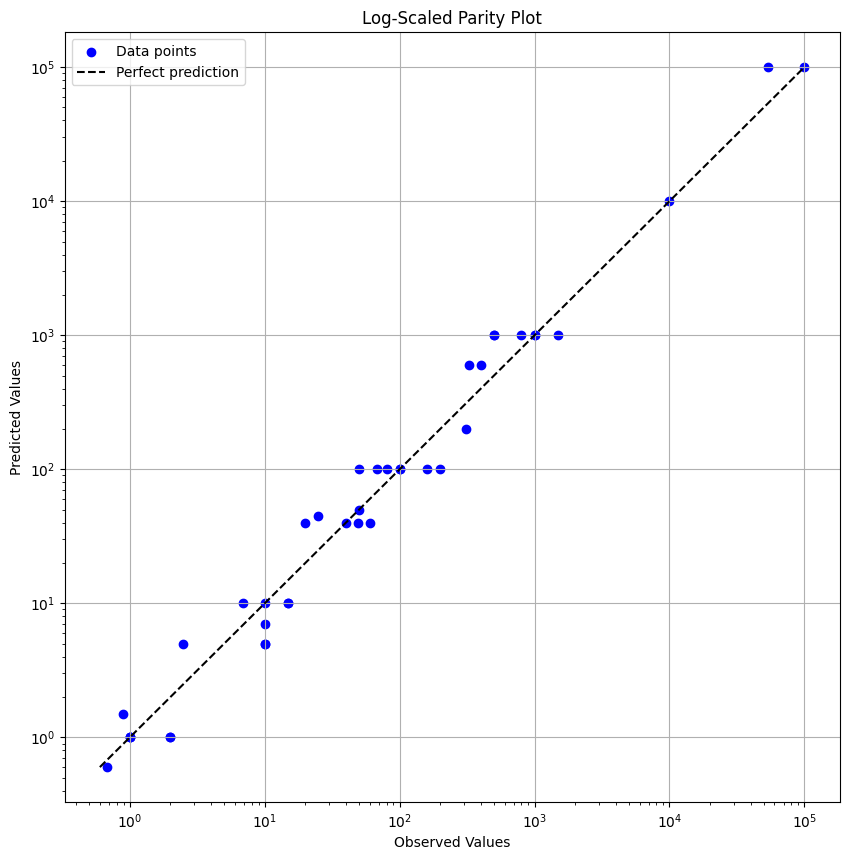

In [ ]:
# Make a parity plot of the ground truth values against the GPT values

# puts the CSV data in a pandas dataframe
data = pd.read_csv(final_data_path, header = None)
column_names = ['Material' , 'GPT Value' , 'GT Value' , 'Percent Difference']
data.columns = column_names
predicted = data['GPT Value']
observed = data['GT Value']

# Some printing
print(len(observed))
print(len(predicted))
print(avg_diff)


plt.figure(figsize=(10, 10))

# Using logarithmic scale because of the large range of values
plt.xscale('log')
plt.yscale('log')

# Scatter plot
plt.scatter(observed, predicted, color='blue', label='Data points')

# Line of perfect prediction
plt.plot([min(observed.min(), predicted.min()), max(observed.max(), predicted.max())],
         [min(observed.min(), predicted.min()), max(observed.max(), predicted.max())],
         'k--', label='Perfect prediction')

# labels
plt.xlabel('Observed Values')
plt.ylabel('Predicted Values')
plt.title('Log-Scaled Parity Plot')

plt.legend()
plt.grid(True)
plt.show()




In [ ]:
filename = PROPERTY.replace(" ", "")+'_'+dtime+'.csv'
print(f"Saving to: {filename} and {filename.replace('csv','txt')}")
print(gpt_dict)

Saving to: Criticalcoolingrate_2024_04_30-205552.csv and Criticalcoolingrate_2024_04_30-205552.txt
{}


Here we set up a structure for the chat. I like to hold the conversation in a list, and then each prompt and response inside it are dictionaries, as per OpenAI requirements. I start with just the system prompt and will append to that later.

I also set up some empty lists and initial values to keep track of progress

This is the main loop that will loop over the prompts, get responses and try to put them in a structured data format.

This while approach is VERY SIMPLE and does not account for many things that may be the response deom the model, so it is only an example to build upon based on the result, not a solution ready to be used. It does not even have to be used at all if one has a better/different idea.

In [ ]:
sss = [{"role": "system", "content": system}]
tab = []
tab_clean = []
ur = 0
um = 0
i = 0

NameError: name 'system' is not defined

In [ ]:
while True:
    # here i send my first prompt first and then loop over the second one over and
    # over again. You will likely have a different approach to this.
    if i<1:
      qq = qs[0]
    else:
      qq = qs[1]
    # save the first prompt to the conversation
    sss.append({"role": "user", "content": qq})
    # send out the first prompt and receive the response
    print(sss)
    sss,ans = prompt(sss)
    # save the response to the conversation
    sss.append({"role": "assistant", "content": ans})

    # we are saving the raw prompts and raw responses, in case we want to analyze
    # or postprocess later
    with open(filename.replace('csv','txt'), 'a') as file:
      print("USER: "+qq, file=file)
      print("GPT : "+ans, file=file)

    # Here we start to grab the data into a nicer structure. For simplicity I had
    # a lot of assumptions. I assume that the word 'value' exists in the header
    # (see first prompt), I remove the header, the separator, and get the rest.
    lines = ans.split('\n')
    if 'value' in lines[0].lower():
      ans = '\n'.join(lines[1:])
    lines = ans.split('\n')
    if '----' in lines[0].lower():
      ans = '\n'.join(lines[1:])
    lines = ans.split('\n')

    # here I try to split the table by columns. I'm assuming that they are
    # separated with |, which is not necessary always the case.
    tab.append(ans)
    try:
      for line in tab[-1].strip().split('\n'):
        tab_clean.append(line.strip('|').split('|'))
    except:
      pass

    # another assumption - only two columns, "material" and "value" (see prompt)
    # some cleanup, converting strings to numbers etc.
    # there is no error handling or edge cases, for example 1.6-1.7 will be removed
    # because it technically is not a number (although it kind of is).
    df = pd.DataFrame(tab_clean, columns=['Material', 'Value'])
    df = df[pd.to_numeric(df['Value'], errors='coerce').notna()]
    df['Value'] = pd.to_numeric(df['Value'])
    df.to_csv(filename, index=False)
    df['Material'] = df['Material'].str.replace('-', '', regex=True)

    # here I count how many new (non-duplicate) materials we are extracting each
    # time, to monitor progress. We stop if more than 10 iterations or not progress
    if len(df.drop_duplicates()) > ur or df['Material'].nunique() > um:
      ur = len(df.drop_duplicates())
      um = df['Material'].nunique()
      i = i+1
      if i > 10:
        print("Stopping due to 10 iterations exceeded")
        break
    else:
      print("Stopping due to NO PROGRESS")
      break

    print(f"Iteration: {i:3} Generated_rows: {len(lines):3};     TOTAL:  Uniq_rows: {len(df.drop_duplicates()):4d}   Uniq_materials: {df['Material'].nunique():4d}")


  # gpt_dict = dict(zip(df['Material'], df['Value']))
  # print(gpt_dict)


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


In [ ]:
import math
import re
import pandas as pd

In [ ]:

# Load the CSV file
file_path = './drive/MyDrive/ML4ER_LLM/Metallic_Glasses_Dataset.csv'
df2 = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df2.head()


In [ ]:
def remove_non_alphanumeric(s):
    if len(s.split()) > 1:
        return None  # Remove the entire string if it has more than one word
    return re.sub(r'[^a-zA-Z0-9]', '', s)

In [ ]:

df_copy = df.copy()
df2_copy = df2[['Composition', 'Rc_[K/s]']].copy()

df2_copy = df2_copy.rename(columns={'Composition': 'Material'})
df2_copy = df2_copy.rename(columns={'Rc_[K/s]': 'Value'})

df_copy['Material'] = df_copy['Material'].apply(remove_non_alphanumeric)
#df2_copy['Material'] = df2_copy['Material'].apply(remove_non_alphanumeric)

df2_copy['Material'] = df2_copy['Material'].apply(lambda x: re.sub(r'[ .]', '', x)).reset_index(drop=True)

df_copy = df_copy.dropna(subset=['Material']).reset_index(drop=True)
df2_copy = df2_copy.dropna(subset=['Material']).reset_index(drop=True)
df2_copy = df2_copy.dropna(subset=['Value']).reset_index(drop=True)

#df2_copy = df2_copy[df2_copy['Material'] != '38Na2O62SiO2'].reset_index(drop=True)
df2_copy


In [ ]:
df2_copy.shape

In [ ]:
len(df2_copy)

In [ ]:
#from pymatgen import Composition

def compare_compounds(compound1, compound2):
    # Create Composition objects
    comp1 = Composition(compound1)
    comp2 = Composition(compound2)

    # Check if the elemental composition is the same
    return comp1.element_composition == comp2.element_composition

In [ ]:
gpt_dict = dict(zip(df_copy['Material'], df_copy['Value']))
#print(gpt_dict)
#print(df2_copy['Value'])
database_dict = dict(zip(df2_copy['Material'], df2_copy['Value']))
correct_dict = {}
print(len(database_dict))
# print(len(database_dict))
# print(database_dict)
same_material = 0
same_value = 0
for gpt_mat in gpt_dict:
  for database_mat in database_dict:
    #print(compare_compounds(gpt_mat, database_mat))
    try:
      if (compare_compounds(gpt_mat, database_mat)):
        print("GPT: " + gpt_mat + " Ground Truth: " + database_mat)
        same_material += 1
        if (gpt_dict[gpt_mat] > database_dict[database_mat]):
          if (gpt_dict[gpt_mat]/database_dict[database_mat] >= 5):
            continue
        else:
          if (database_dict[database_mat]/gpt_dict[gpt_mat] >= 5):
            continue
          # abs(gpt_dict[gpt_mat] - database_dict[database_mat])/database_dict[database_mat] <= 5
          #print(abs(gpt_dict[gpt_mat] - database_dict[database_mat]) * 100)
          same_value += 1
          print(f'GPT: {gpt_mat}, {gpt_dict[gpt_mat]}     GT: {database_mat}, {database_dict[database_mat]}')
          correct_dict[gpt_mat] = [gpt_dict[gpt_mat],database_dict[database_mat]]
          correct_list = [database_mat , database_dict[database_mat] , gpt_dict[gpt_mat]]
          # Specify the file name
          filename = '/content/gptdata.csv'
          with open(filename, 'a') as f_obj:
    # creating a csv writer object
            csvwriter = csv.writer(f_obj)
    # writing the fields
            #csvwriter.writerow(fields)
    # writing the data rows
            csvwriter.writerow(correct_list)
    except Exception as e:
        # Handle other types of errors
        print("Error: " + str(gpt_mat) + ",  " + str(database_mat))
print(f'\nsame material: {same_material}')
print(f'\nsame value: {same_value}')
print(f'\nsuccess rate based on GPT: {same_material/len(gpt_dict)}')
# print(correct_dict)
# len(correct_dict)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
print(len(gpt_dict))
print(len(database_dict))